In [ ]:
!pip install LightGBM

In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,OrdinalEncoder, StandardScaler,MinMaxScaler,Normalizer
from sklearn.compose import  make_column_transformer,make_column_selector as selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_squared_log_error
import lightgbm as lgm
from lightgbm import LGBMRegressor

In [446]:
train=pd.read_csv('TRAIN (3).csv')
submission=pd.read_csv('SAMPLE.csv')
test=pd.read_csv('TEST_FINAL.csv')

In [322]:
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [325]:
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


NO null values with mixed data type

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [4]:
train.astype(object).describe()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
count,63522,63522,63522,63522,63522,63522,63522,63522,63522,63521.0
unique,63522,365,4,5,4,175,2,2,245,26130.0
top,T1004668,220,S1,L1,R1,2018-02-08,0,No,53,35853.0
freq,1,175,29933,28713,21579,365,55857,33721,1247,16.0


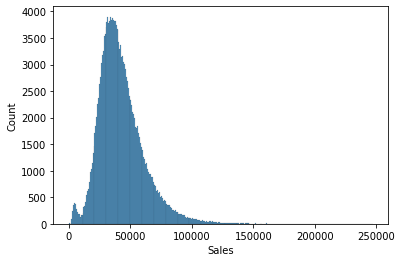

In [15]:
sns.histplot(data=train,x='Sales')

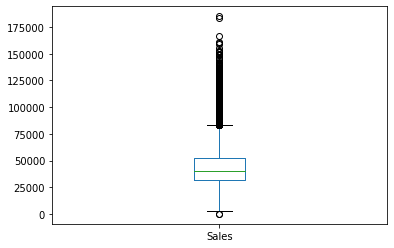

In [35]:
train.Sales.plot(kind='box')

In [448]:
train=train[train.Sales < 150000]

In [ ]:
train.head()

In [449]:
train['Date']=train.Date.astype('datetime64')
test['Date']=test.Date.astype('datetime64')

In [450]:
train['day_name']=train.Date.dt.day_name()
test['day_name']=test.Date.dt.day_name()
train['month_of_sale']=train.Date.dt.month
test['month_of_sale']=test.Date.dt.month

# Sale on weekend is more as compared to other days

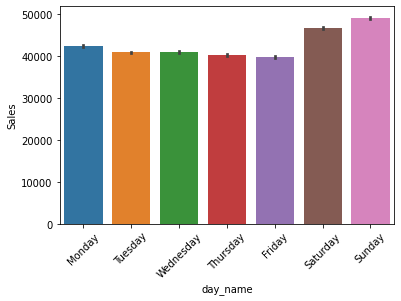

In [26]:
plt.xticks(rotation=45)
sns.barplot(x='day_name',y='Sales',data=train)


In [ ]:
plt.bar(train.Date.dt.month,train.Sales)

New feature if it is weekend or not

In [451]:
train['Weekend']=np.where(train.Date.dt.day_name().isin(['Sunday','Saturday']),1,0)
test['Weekend']=np.where(test.Date.dt.day_name().isin(['Sunday','Saturday']),1,0)

Sales is more on month of January and May and Jun compartively


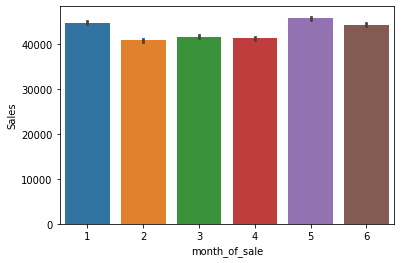

In [19]:
sns.barplot(x='month_of_sale',y='Sales',data=train)


only 2018 year sales are present in training data

More sale  happens when Discount is given

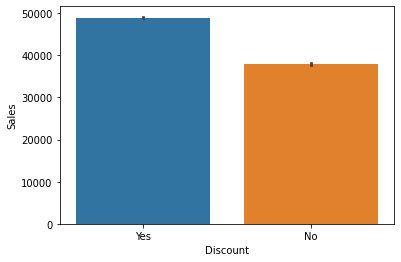

In [24]:
sns.barplot(x='Discount',y='Sales',data=train)

In Region Code R1 more sales happens as compared to other region

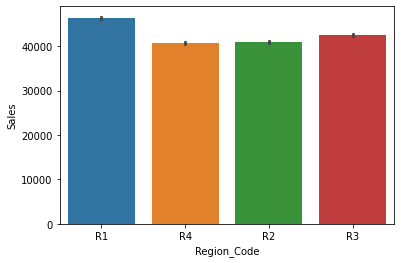

In [26]:
sns.barplot(x='Region_Code',y='Sales',data=train)

DIfferent location has different sales with location L2 having most sales

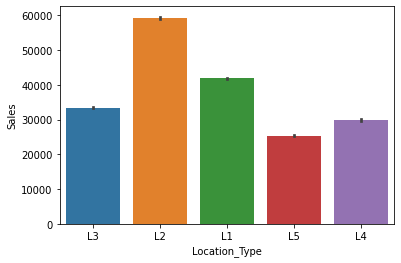

In [28]:
sns.barplot(x='Location_Type',y='Sales',data=train)

Mostly Different store have different sales

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(x='Store_id',y='Sales',data=train)

In [452]:
train= train_.copy(deep=True)
train.dropna(axis=0,inplace=True)
Y=train['Sales']


In [453]:
train.drop(['ID','Date','Sales'],axis=1,inplace=True)

#test.drop(['ID','Date'],axis=1,inplace=True)

In [454]:
train=train.astype(str)
test=test.astype(str)

In [458]:
train['#Order']=train['#Order'].astype(int)

In [379]:
#train[['per_unit_sale','#Order']]=train[['per_unit_sale','#Order']].astype(float)

In [459]:
x_train, x_test, y_train, y_test=train_test_split(train,Y.ravel(),test_size=.2)

In [460]:
onehot=OneHotEncoder(handle_unknown='ignore')

standard_scaler=StandardScaler()

In [481]:
preprocessor=make_column_transformer((standard_scaler,selector(dtype_exclude=object)),(onehot,selector(dtype_include=object))) #,

In [462]:
#model=LGBMRegressor(n_estimators=50,num_leaves=30) # ---predict sales price
model=LGBMRegressor(n_estimators=60)  #predict number of order
#model=LGBMRegressor(n_estimators=150 #predict unit_per_sale

In [482]:
pipeline=make_pipeline(preprocessor,model)

In [ ]:
pipeline.get_params()

In [484]:
grid=GridSearchCV(pipeline,param_grid={'lgbmregressor__num_leaves':[32]},scoring='neg_mean_squared_log_error')

In [485]:
grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc

In [466]:
grid.best_params_

{'lgbmregressor__num_leaves': 32}

In [486]:
prediction=grid.predict(x_test)

In [487]:
mean_squared_log_error(y_test,prediction) #0.005525763718138175

0.011929879679614673

In [488]:
mean_squared_log_error(y_train,grid.predict(x_train)) #0.011673122818690415

0.014032616415884866

In [489]:
np.round(prediction,2)[:10]

array([26727.33, 31622.47,  5899.13, 30224.39, 40406.92, 23091.56,
       61875.28, 32636.22, 43178.88, 26910.77])

In [471]:
y_test[:10]

array([27039.  , 32889.  ,  5254.56, 25542.  , 37020.  , 23058.  ,
       58848.  , 33051.  , 37860.  , 26202.  ])

In [392]:
np.where(prediction<0)

(array([ 2188,  5834, 11209, 23710, 30065]),)

In [494]:
test=test[train.columns]
prediction=grid.predict(test)

In [476]:
#test['#Order']=prediction
#test['#Order']=test['#Order'].apply(round)
#test=test_.copy(deep=True)

In [495]:
submission['Sales']=prediction

In [496]:
from datetime import datetime

In [497]:
submission.to_csv('prediction_{}.csv'.format(datetime.now().time()),index=False)

In [498]:
!ls

 prediction_15:40:55.358818.csv   SAMPLE.csv
 prediction_15:51:34.954315.csv   sample_data
 prediction_17:20:20.160513.csv   TEST_FINAL.csv
 prediction_17:51:35.961924.csv  'TRAIN (3).csv'


In [499]:
from google.colab import files
files.download('/content/prediction_17:51:35.961924.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>